In [1]:
import pandas as pd
import numpy as np
import datetime
import os.path

%matplotlib inline

In [2]:
airport_name = 'ATH'

In [3]:
sch_data_path = 'Data/Raw OAG/' + airport_name + '_Schedules_data.csv' 
data = pd.read_csv(sch_data_path)

In [4]:
#Check data correspond to correct airport
if data['Dep Airport Code'].nunique() != 1 or data['Dep Airport Code'][0]!=airport_name:
        raise ValueError('Check OAG data (is the Dep Airport correct?).')

In [5]:
#function that converts time from string to datetime format
def conv_date(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

In [6]:
#Convert 'Time series' from string to datetime and create new 'Year' and 'Month' columns
data['Time series'] = data['Time series'].apply(lambda x: datetime.date(int(x[:4]), int(x[5:7]), int(x[8:10])))
data['Year'] = data['Time series'].apply(lambda x: x.year)
data['Month'] = data['Time series'].apply(lambda x: x.month)
data['Season'] = data['Month'].apply(lambda x: 'Summer' if (x>=4) & (x<11) else 'Winter')

In [7]:
data.shape

(191075, 25)

In [8]:
#Add consolidated regions column
regions = pd.read_csv('Data/regions_lookup.csv')
data = data.merge(regions,left_on=['Arr Region Name'],right_on=['Region (OAG)']).drop(['Region (OAG)'],axis=1)
data.loc[data['International/Domestic']=='Domestic','Region'] = 'Domestic'

In [9]:
#Sort by date
data = data.sort_values('Time series')

In [10]:
data_grouped = pd.DataFrame(data.groupby(['Carrier Code', 'Arr Airport Code', 'Time series'])['Frequency','Seats (Total)'].sum())
data = data.merge(data_grouped.drop('Seats (Total)',axis=1),left_on=['Carrier Code', 'Arr Airport Code', 'Time series'], right_on=['Carrier Code', 'Arr Airport Code', 'Time series']).rename({'Frequency_x':'Frequency','Frequency_y':'total_freq'},axis='columns')

In [11]:
data.shape

(191075, 27)

In [12]:
data.columns

Index(['Carrier Code', 'Carrier Name', 'Dep Airport Code', 'Dep Airport Name',
       'Dep City Name', 'Dep IATA Country Name', 'Dep Region Name',
       'Arr Airport Code', 'Arr Airport Name', 'Arr IATA Country Name',
       'Arr Region Name', 'International/Domestic', 'Local Days Of Op',
       'Flying Time', 'Specific Aircraft Code', 'Specific Aircraft Name',
       'GCD (km)', 'Mainline/Low Cost', 'Service Type', 'Frequency',
       'Seats (Total)', 'Time series', 'Year', 'Month', 'Season', 'Region',
       'total_freq'],
      dtype='object')

In [13]:
limit_is_route = 30/7/2 #number of monthly frequencies for entry to be considered route

In [14]:
def freq_check_month(x, limit):
    return 1 if x >= limit else 0

data['is_route'] = data['total_freq'].apply(lambda x: freq_check_month(x, limit_is_route))

### Pax data

In [15]:
def import_pax_data(airport_name):
    ''' function used to import OAG Pax data, which may be split into multiple files due to size limits'''
    if os.path.isfile('Data/Raw OAG/' + airport_name + '_Pax_data.csv'):
        data_ = pd.read_csv('Data/Raw OAG/' + airport_name + '_Pax_data.csv')
    elif os.path.isfile ('Data/Raw OAG/' + airport_name + '_Pax_data_1.csv'):
        data_ = pd.read_csv('Data/Raw OAG/' + airport_name + '_Pax_data_1.csv')
    
    for i in range(2,6):
        pax_path = 'Data/Raw OAG/' + airport_name + '_Pax_data_' + str(i) + '.csv'
        if os.path.isfile(pax_path):
            data_ = data_.append(pd.read_csv(pax_path))
            
    if data_['Dep Airport Code'].nunique() != 1 or data_['Dep Airport Code'].values[0]!=airport_name:
        raise ValueError('Check OAG data (is the Dep Airport correct?).')
    
    return data_

In [16]:
pax_data = import_pax_data(airport_name)

In [17]:
#Convert 'Time series' from string to datetime and create new 'Year' and 'Month' columns
pax_data['Time series'] = pax_data['Time Series'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), 1))
pax_data['Year'] = pax_data['Time series'].apply(lambda x: x.year)
pax_data['Month'] = pax_data['Time series'].apply(lambda x: x.month)
pax_data['Season'] = pax_data['Month'].apply(lambda x: 'Summer' if (x>=4) & (x<11) else 'Winter')
pax_data = pax_data.drop('Time Series', axis=1)

In [18]:
#Determine if pax is transfer or OD and store next destination
pax_data['Direct/Indirect'] = pax_data['Gateway1 Airport Code'].apply(lambda x: 'Direct' if pd.isnull(x) or x=="" else 'Indirect')
pax_data['NextDest'] = pax_data[['Gateway1 Airport Code','Arr Airport Code']].apply(lambda x: x['Arr Airport Code'] if pd.isnull(x['Gateway1 Airport Code']) else x['Gateway1 Airport Code'], axis=1)

In [19]:
od_pax_data_Season_routes = pd.DataFrame(pax_data.groupby(['Arr Airport Code', 'Year', 'Season','Direct/Indirect'],as_index=False)['Total Est. Pax'].sum()).sort_values(['Arr Airport Code','Direct/Indirect','Year','Season'])
segment_pax_data_Season = pd.DataFrame(pax_data.groupby(['Pub. Al. Code (Dominant)', 'NextDest', 'Year', 'Season','Direct/Indirect'],as_index=False)['Total Est. Pax'].sum()).sort_values(['Pub. Al. Code (Dominant)','NextDest','Year','Season','Direct/Indirect'])

***Monthly Data - by Airline***

In [ ]:
data_monthly = pd.DataFrame(data[data['is_route']==1].groupby(['Carrier Code','Arr Airport Code','Arr IATA Country Name','Region','Time series'],as_index=False)['Frequency'].sum())

In [ ]:
#add prev year frequencies
data_monthly['prev_year_date'] = data_monthly['Time series'].apply(lambda x: x - pd.DateOffset(years=1))
data_monthly_full = data_monthly.merge(data_monthly.iloc[:,0:-1], how = 'left', left_on = ['Carrier Code', 'Arr Airport Code', 'prev_year_date'], right_on = ['Carrier Code', 'Arr Airport Code', 'Time series'])
data_monthly_full = data_monthly_full.sort_values(['Carrier Code', 'Arr Airport Code', 'Time series_x']).rename(columns={'Time series_x':'Time_series','Frequency_x':'Frequency','Frequency_y':'Frequency_prev_year','Region_x':'Region'}).drop(['Time series_y','Region_y'],axis=1)

In [ ]:
#add prev month frequencies
data_monthly_full['prev_month_date'] = data_monthly_full['Time_series'].apply(lambda x: x - pd.DateOffset(months=1))
data_monthly_full = data_monthly_full.merge(data_monthly.iloc[:,0:-1], how = 'left', left_on = ['Carrier Code', 'Arr Airport Code', 'prev_month_date'], right_on = ['Carrier Code', 'Arr Airport Code', 'Time series'])
data_monthly_full = data_monthly_full.drop(['Time series'],axis=1).rename(columns={'Frequency_x':'Frequency','Frequency_y':'Frequency_prev_month','Arr IATA Country Name_x':'Arr IATA Country Name','Region_x':'Region'}).drop(['Arr IATA Country Name_y','Region_y'],axis=1)

In [ ]:
data_monthly_full.head()

***Routes (not by airline)***

In [20]:
routes_season = pd.DataFrame(data.groupby(['Arr Airport Code','Year', 'Season'],as_index=False)['Frequency','Seats (Total)'].sum())

In [21]:
#add prev year frequencies
routes_season['prev_year'] = routes_season['Year'].apply(lambda x: x-1) 
routes_season_full = routes_season.merge(routes_season.iloc[:,0:-1], how = 'left', left_on = ['Arr Airport Code', 'prev_year', 'Season'], right_on = ['Arr Airport Code',  'Year', 'Season'],validate = 'm:1')
routes_season_full = routes_season_full.sort_values(['Arr Airport Code', 'Year_x']).rename(columns={'Year_x':'Year','Frequency_x':'Frequency','Frequency_y':'Frequency_prev_year','Seats (Total)_x':'Seats (Total)','Seats (Total)_y':'Seats_prev_year'}).drop(['Year_y'],axis=1)


In [22]:
#add region to routes_season_full
routes_season_full = routes_season_full.merge(data[['Arr Airport Code','Region']].drop_duplicates(subset=['Arr Airport Code']),how='left',on=['Arr Airport Code'],validate = 'm:1')

In [23]:
def freq_check_season(x, season, limit_month):
    if season == 'Summer':
        limit = 7*limit_month
    else:
        limit = 5*limit_month
    if x >= limit or np.isnan(x):
        out = 1
    else:
        out = 0
    return out

In [24]:
routes_season_full['is_route'] = routes_season_full[['Frequency','Season']].apply(lambda x: freq_check_season(*x,limit_is_route),axis=1)

In [25]:
def is_new(x,season,limit_month):
    if season == 'Summer':
        limit = 7*limit_month
    else:
        limit = 5*limit_month 
    return 1 if (np.isnan(x)) or (x < limit) else 0

def freq_change(x,y):
    if y-x > 0 or np.isnan(x):
        freq_diff = -1
    elif y-x < 0 or np.isnan(y):
        freq_diff = 1
    else:
        freq_diff = 0
    return freq_diff

In [26]:
routes_season_full['is_new'] = routes_season_full[['Frequency_prev_year','Season']].apply(lambda x: is_new(*x,limit_is_route), axis=1)
routes_season_full['yoychange'] = routes_season_full[['Frequency','Frequency_prev_year']].apply(lambda x: freq_change(*x),axis=1)

***Season Data - by Airline***

In [48]:
data_season = pd.DataFrame(data.groupby(['Carrier Code', 'Arr Airport Code', 'Year', 'Season'],as_index=False)['Frequency','Seats (Total)'].sum())

**Add negative samples (i.e. routes that could have started but didn't)**

In [49]:
#Get top ultimate destinations by region
#Weighted sum of Direct/Indirect (if ind_weight=1 (default) then total sum is obtained, otherwise weighted average)
ind_weight = 0.7

top_dest = pd.DataFrame(od_pax_data_Season_routes[od_pax_data_Season_routes['Direct/Indirect']=='Direct'].groupby(['Arr Airport Code','Year'],as_index=False)['Total Est. Pax'].sum()).rename(columns={'Total Est. Pax':'Direct Pax'})
top_ind = pd.DataFrame(od_pax_data_Season_routes[od_pax_data_Season_routes['Direct/Indirect']=='Indirect'].groupby(['Arr Airport Code','Year'],as_index=False)['Total Est. Pax'].sum()).rename(columns={'Total Est. Pax':'Indirect Pax'})
top_dest = top_dest.merge(top_ind,how='outer',on=['Arr Airport Code','Year'])
top_dest['Direct Pax'] = top_dest['Direct Pax'].fillna(0)
top_dest['Indirect Pax'] = top_dest['Indirect Pax'].fillna(0)
top_dest['Total Est. Pax'] = top_dest[['Direct Pax','Indirect Pax']].apply(lambda x: (1 if ind_weight==1 else 1-ind_weight)*x['Direct Pax']+ind_weight*x['Indirect Pax'],axis=1)

top_dest = top_dest.merge(pax_data[['Arr Airport Code','Arr Region Name','International/Domestic']].drop_duplicates('Arr Airport Code'),how='left',on=['Arr Airport Code'],validate = 'm:1')
top_dest = top_dest.merge(regions,how='left',left_on=['Arr Region Name'],right_on=['Region (OAG)']).drop(['Arr Region Name','Region (OAG)'],axis=1)
top_dest.loc[top_dest['International/Domestic']=='Domestic','Region'] = 'Domestic'
top_dest = top_dest.sort_values(['Year','Region','Total Est. Pax'],ascending=False).reset_index(drop=True)

In [50]:
#Get top regions by airline (all time)
airline_region = data.groupby(['Carrier Code','Region'],as_index=False)['Seats (Total)'].sum().sort_values(['Carrier Code','Seats (Total)'],ascending=False).reset_index(drop=True)

airline_region['order'] = 1
for i in range(1,len(airline_region)):
    if airline_region.loc[i,'Carrier Code']==airline_region.loc[i-1,'Carrier Code']:
        airline_region.loc[i,'order'] = airline_region.loc[i-1,'order']+1 
        
airline_region_top = pd.DataFrame(airline_region['Carrier Code'].unique(),columns=['Carrier Code'])
airline_region_top = airline_region_top.merge(airline_region[airline_region['order']==1][['Carrier Code','Region']],how='left',on=['Carrier Code']).rename(columns={'Region':'Region_1'})
airline_region_top = airline_region_top.merge(airline_region[airline_region['order']==2][['Carrier Code','Region']],how='left',on=['Carrier Code']).rename(columns={'Region':'Region_2'})

In [51]:
airline_season = data_season[['Carrier Code','Year','Season']].drop_duplicates().reset_index(drop=True)

In [52]:
for i in range(len(airline_season)):
    for j in ['Region_1','Region_2']:

        airline = airline_season['Carrier Code'][i]
        year = airline_season['Year'][i]
        season = airline_season['Season'][i]
        region = airline_region_top[airline_region_top['Carrier Code']==airline][j].values[0]
        
        if not pd.isna(region):
            #get current and last year's airline routes
            airline_routes = data_season[(data_season['Carrier Code']==airline)&(~pd.isnull(data_season['Frequency']))&(data_season['Year'].isin([year,year-1]))]['Arr Airport Code'].values
        
            #randomely choose negative routes and append to data_season
            dest_pool = top_dest[(top_dest['Region']==region)&(top_dest['Year']==year)&(~top_dest['Arr Airport Code'].isin(airline_routes))]
            if len(dest_pool)==0:
                dest_pool = top_dest[(top_dest['Region']==region)&(top_dest['Year']==top_dest['Year'].min())&(~top_dest['Arr Airport Code'].isin(airline_routes))]
                
            dest_pool = dest_pool[dest_pool['Total Est. Pax']>=dest_pool['Total Est. Pax'].quantile(0.6)]['Arr Airport Code']
            if len(dest_pool)>=2:
                neg_routes = pd.DataFrame(np.random.choice(dest_pool,2,replace=False),columns=['Arr Airport Code'])
                neg_routes['Carrier Code'] = airline
                neg_routes['Year'] = year
                neg_routes['Season'] = season
        
                data_season = data_season.append(neg_routes,sort=True,ignore_index=True)

In [53]:
len(data_season[pd.isnull(data_season['Frequency'])])/len(data_season)

0.47338990855864743

*Comparison with previous year (airline-route & route level)*

In [54]:
#add prev year (same season) frequencies
data_season['prev_year'] = data_season['Year'].apply(lambda x: x-1)
data_season_full = data_season.merge(data_season[['Carrier Code', 'Arr Airport Code', 'Year', 'Season', 'Frequency']], how = 'left', left_on = ['Carrier Code', 'Arr Airport Code', 'prev_year', 'Season'], right_on = ['Carrier Code', 'Arr Airport Code',  'Year', 'Season'],validate = 'm:1')
data_season_full = data_season_full.sort_values(['Carrier Code', 'Arr Airport Code', 'Year_x']).rename(columns={'Year_x':'Year','Frequency_x':'Frequency','Frequency_y':'Frequency_prev_year'}).drop(['Year_y'],axis=1)

In [55]:
#check if route/airline pair is new
data_season_full['is_new_route_airline'] = data_season_full[['Frequency_prev_year','Season']].apply(lambda x: is_new(*x,limit_is_route),axis=1)

In [56]:
#combine with route level data to see if destination is new
data_season_full = data_season_full.merge(routes_season_full[['Arr Airport Code','Year','Season','Frequency_prev_year','is_new']], how = 'left', on = ['Arr Airport Code','Year','Season'],validate = 'm:1').rename(columns={'Frequency_prev_year_x':'Frequency_prev_year', 'Frequency_prev_year_y':'Frequency_prev_year_route','is_new':'is_new_route'})
data_season_full['is_new_route'] = data_season_full['is_new_route'].fillna(1)

In [57]:
data_season_full.head()

,Arr Airport Code,Carrier Code,Frequency,Season,Seats (Total),Year,prev_year,Frequency_prev_year,is_new_route_airline,Frequency_prev_year_route,is_new_route
0,AOK,0B,NaN,Winter,NaN,2017,2016,NaN,1,148.0,0.0
1,AOK,0B,6.0,Summer,276.0,2018,2017,NaN,1,423.0,0.0
2,AXD,0B,NaN,Summer,NaN,2015,2014,NaN,1,551.0,0.0
3,AXD,0B,NaN,Winter,NaN,2020,2019,NaN,1,603.0,0.0
4,AYT,0B,NaN,Summer,NaN,2019,2018,NaN,1,NaN,1.0


In [58]:
#remove rows with small number of frequencies (i.e. not real routes)
data_season_full['is_route'] = data_season_full[['Frequency','Season']].apply(lambda x: freq_check_season(*x,limit_is_route),axis=1)
data_season_full = data_season_full[data_season_full['is_route']==1].drop(columns=['is_route'])

In [59]:
#determine if airline is new at airport (i.e. no flights last year same season)
airline_freq = data_season.groupby(['Carrier Code','Year','Season'],as_index=False)['Frequency'].sum()
data_season_full = data_season_full.merge(airline_freq,how='left',left_on=['Carrier Code','prev_year','Season'],right_on=['Carrier Code','Year','Season'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','Frequency_x':'Frequency','Frequency_y':'Frequency_prev_airline'}).drop(['Year_y'],axis=1)
data_season_full['is_new_airline'] = data_season_full['Frequency_prev_airline'].apply(lambda x: 1 if np.isnan(x)==True else 0)
data_season_full = data_season_full.drop(['Frequency_prev_airline'],axis=1)

In [60]:
#clasisfy freq change vs. prev year for route-airline pair 
data_season_full['yoychange'] = data_season_full[['Frequency','Frequency_prev_year']].apply(lambda x: freq_change(*x),axis=1)
data_season_full.loc[pd.isnull(data_season_full['Frequency']),'yoychange'] = 1

In [61]:
#add number of airlines with flights to each destination in the previous year
airlines_by_route = data_season_full[~pd.isnull(data_season_full['Frequency'])][['Carrier Code','Arr Airport Code','Year','Season']].groupby(['Arr Airport Code','Year','Season'],as_index=False).agg({'Carrier Code': pd.Series.nunique})
data_season_full = data_season_full.merge(airlines_by_route, how = 'left', left_on = ['Arr Airport Code','prev_year','Season'], right_on = ['Arr Airport Code','Year','Season'],validate = 'm:1').rename(columns={'Carrier Code_x':'Carrier Code','Year_x':'Year','Carrier Code_y':'n_airlines_prev_year'}).drop(['Year_y'],axis=1)
data_season_full['n_airlines_prev_year'] = data_season_full['n_airlines_prev_year'].fillna(0)

*Previous year trends (vs year before)*

In [62]:
#prev year vs year before freq. % change for airline-route
data_season_full['pct_change'] = data_season_full[['is_new_route_airline','Frequency','Frequency_prev_year']].apply(lambda x: x['Frequency']/x['Frequency_prev_year']-1 if x['is_new_route_airline']==0 else 'New', axis=1)
data_season_full = data_season_full.merge(data_season_full[['Carrier Code','Arr Airport Code','Season','Year','pct_change']],how='left',left_on = ['Carrier Code','Arr Airport Code','Season','prev_year'], right_on = ['Carrier Code','Arr Airport Code','Season','Year'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','pct_change_y':'pct_change_prev'}).drop(['Year_y','pct_change_x'],axis=1)

In [68]:
data_season_full.loc[pd.isnull(data_season_full['Frequency']),'pct_change_prev'] = 0
data_season_full['pct_change_prev'] = data_season_full['pct_change_prev'].fillna(0)
data_season_full.loc[data_season_full['pct_change_prev']=='New','pct_change_prev'] = float('NaN')

In [70]:
#prev year vs year before freq. % change for airline (all routes)
airline_freq['prev_year'] = airline_freq['Year'].apply(lambda x: x-1)
airline_freq = airline_freq.merge(airline_freq,how='left',left_on=['Carrier Code','prev_year','Season'],right_on=['Carrier Code','Year','Season'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','prev_year_x':'prev_year','Frequency_x':'Frequency','Frequency_y':'Frequency_prev'}).drop(['Year_y','prev_year_y'],axis=1)
airline_freq['pct_change'] = airline_freq.apply(lambda x: x['Frequency']/x['Frequency_prev']-1 if x['Frequency_prev']>0 else 'New airline' , axis=1)

data_season_full = data_season_full.merge(airline_freq[['Carrier Code','Season','Year','pct_change']],how='left',left_on = ['Carrier Code','Season','prev_year'], right_on = ['Carrier Code','Season','Year'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','pct_change':'pct_change_prev_airline'}).drop(['Year_y'],axis=1)

data_season_full['pct_change_prev_airline'] = data_season_full['pct_change_prev_airline'].fillna(0)
data_season_full.loc[data_season_full['pct_change_prev_airline']=='New airline','pct_change_prev_airline'] = float('NaN')

In [72]:
#prev year vs year before freq. % change for route
routes_season_full['pct_change'] = routes_season_full[['is_new','Frequency','Frequency_prev_year']].apply(lambda x: x['Frequency']/x['Frequency_prev_year']-1 if x['is_new']==0 else 'New', axis=1)
data_season_full = data_season_full.merge(routes_season_full[['Arr Airport Code','Season','Year','pct_change']],how='left',left_on = ['Arr Airport Code','Season','prev_year'], right_on = ['Arr Airport Code','Season','Year'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','pct_change':'pct_change_prev_route'}).drop(['Year_y'],axis=1)

data_season_full['pct_change_prev_route'] = data_season_full['pct_change_prev_route'].fillna(0)
data_season_full.loc[data_season_full['pct_change_prev_route']=='New','pct_change_prev_route'] = float('NaN')

In [ ]:
#UPDATE

#add region to data_season_full
data_season_full = data_season_full.merge(data[['Arr Airport Code','Region']].drop_duplicates(subset=['Arr Airport Code']),how='left',on=['Arr Airport Code'],validate = 'm:1')

regions_pax = pax_data[['Arr Airport Code', 'Arr Region Name', 'International/Domestic']].drop_duplicates(subset=['Arr Airport Code'])
regions_pax = regions_pax.merge(regions,left_on=['Arr Region Name'],right_on=['Region (OAG)']).drop(['Region (OAG)'],axis=1)
regions_pax.loc[regions_pax['International/Domestic']=='Domestic','Region'] = 'Domestic'

data_season_full = data_season_full.merge(regions_pax[['Arr Airport Code','Region']],how='left',on=['Arr Airport Code'],validate = 'm:1')
data_season_full['Region'] = data_season_full[['Region_x','Region_y']].apply(lambda x: x.Region_x if pd.isnull(x.Region_x)==False else x.Region_y,axis=1)
data_season_full = data_season_full.drop(['Region_x','Region_y'],axis=1)

In [ ]:
#prev year vs year before freq. % change for region
region_season = pd.DataFrame(routes_season_full.groupby(['Region','Year','Season'],as_index=False)['Frequency'].sum())
region_season['prev_year'] = region_season['Year'].apply(lambda x: x-1)
region_season = region_season.merge(region_season,how='left',left_on=['Region','prev_year','Season'],right_on=['Region','Year','Season'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','prev_year_x':'prev_year','Frequency_x':'Frequency','Frequency_y':'Frequency_prev'}).drop(['Year_y','prev_year_y'],axis=1)
region_season['pct_change'] = region_season.apply(lambda x: x['Frequency']/x['Frequency_prev']-1, axis=1)

#add region's prev year yoy
data_season_full = data_season_full.merge(region_season[['Region','Season','Year','pct_change']],how='left',left_on = ['Region','Season','prev_year'], right_on = ['Region','Season','Year'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','pct_change':'pct_change_prev_region'}).drop(['Year_y'],axis=1)

In [ ]:
#prev year vs year before freq. % change for dep airport
airport_freq=routes_season.groupby(['Year','Season'],as_index=False)['Frequency'].sum()
airport_freq['prev_year'] = airport_freq['Year'].apply(lambda x: x-1)
airport_freq = airport_freq.merge(airport_freq,how='left',left_on=['prev_year','Season'],right_on=['Year','Season'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','prev_year_x':'prev_year','Frequency_x':'Frequency','Frequency_y':'Frequency_prev'}).drop(['Year_y','prev_year_y'],axis=1)
airport_freq['pct_change'] = airport_freq.apply(lambda x: x['Frequency']/x['Frequency_prev']-1, axis=1)

data_season_full = data_season_full.merge(airport_freq[['Season','Year','pct_change']],how='left',left_on = ['Season','prev_year'], right_on = ['Season','Year'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','pct_change':'pct_change_prev_airport'}).drop(['Year_y'],axis=1)

*Route success - Comparison with next year*

In [ ]:
data_season_full.head()

In [ ]:
#add next year (same season) frequencies
data_season_full['next_year'] = data_season_full['Year'].apply(lambda x: x+1)
data_season_full = data_season_full.merge(data_season[['Carrier Code', 'Arr Airport Code', 'Year', 'Season', 'Frequency']], how = 'left', left_on = ['Carrier Code', 'Arr Airport Code', 'next_year', 'Season'], right_on = ['Carrier Code', 'Arr Airport Code',  'Year', 'Season'],validate = 'm:1')
data_season_full = data_season_full.sort_values(['Carrier Code', 'Arr Airport Code', 'Year_x']).rename(columns={'Year_x':'Year','Frequency_x':'Frequency','Frequency_y':'Frequency_next_year','Region_x':'Region'}).drop(['Year_y'],axis=1)

In [ ]:
#clasisfy change in next year (i.e. was route successful)
data_season_full['stopped_next_year'] = data_season_full[['Frequency_next_year','Season']].apply(lambda x: is_new(*x,limit_is_route),axis=1)
data_season_full.loc[pd.isnull(data_season_full['Frequency']),'stopped_next_year'] = np.nan
data_season_full['yoychange_next'] = data_season_full[['Frequency_next_year','Frequency']].apply(lambda x: freq_change(*x),axis=1)
data_season_full.loc[pd.isnull(data_season_full['Frequency']),'yoychange_next'] = np.nan

In [ ]:
data_season_full = data_season_full.drop(['prev_year','next_year'],axis=1)

In [ ]:
data_season_full.head()

In [ ]:
data_season_full.shape

*Seasonality check*

In [ ]:
#Determine if route is Seasonal (are there any frequency in next/prev season)
data_season_full['Prev_Season'] = data_season_full['Season'].apply(lambda x: 'Summer' if x=='Winter' else 'Winter')
data_season_full['Prev_Year'] = data_season_full[['Year','Prev_Season']].apply(lambda x: x.Year - 1 if x.Prev_Season=='Winter' else x.Year, axis=1)
data_season_full['Next_Season'] = data_season_full['Season'].apply(lambda x: 'Summer' if x=='Winter' else 'Winter')
data_season_full['Next_Year'] = data_season_full[['Year','Next_Season']].apply(lambda x: x.Year + 1 if x.Next_Season=='Summer' else x.Year, axis=1)

data_season_full = data_season_full.merge(data_season_full[['Carrier Code','Arr Airport Code','Season','Year','Frequency']], how = 'left', left_on = ['Carrier Code','Arr Airport Code','Prev_Season','Prev_Year'], right_on = ['Carrier Code','Arr Airport Code','Season','Year'],validate = 'm:1')\
    .rename(columns = {'Season_x':'Season','Year_x':'Year','Frequency_x':'Frequency','Frequency_y':'Frequency_Prev_Season'}).drop(['Prev_Season','Prev_Year','Season_y','Year_y'],axis=1)
data_season_full = data_season_full.merge(data_season_full[['Carrier Code','Arr Airport Code','Season','Year','Frequency']], how = 'left', left_on = ['Carrier Code','Arr Airport Code','Next_Season','Next_Year'], right_on = ['Carrier Code','Arr Airport Code','Season','Year'],validate = 'm:1')\
    .rename(columns = {'Season_x':'Season','Year_x':'Year','Frequency_x':'Frequency','Frequency_y':'Frequency_Next_Season'}).drop(['Next_Season','Next_Year','Season_y','Year_y'],axis=1)

data_season_full['Seasonal'] = data_season_full[['Frequency_Prev_Season','Frequency_Next_Season']].apply(lambda x: 1 if np.isnan(x.Frequency_Prev_Season) and np.isnan(x.Frequency_Next_Season) else 0, axis=1)

#assign random seasonality to negatives
data_season_full.loc[pd.isnull(data_season_full['Frequency']),'Seasonal'] = data_season_full.loc[pd.isnull(data_season_full['Frequency']),'Seasonal'].apply(lambda x: np.random.randint(0, 2))

** Add Pax data to schedules **

In [ ]:
#add last year's (same season) direct & indirect pax for Origin/Final dest pair
data_season_full['prev_year'] = data_season_full['Year'].apply(lambda x: x-1)
data_season_full = data_season_full.merge(od_pax_data_Season_routes[od_pax_data_Season_routes['Direct/Indirect']=='Indirect'], how = 'left', left_on = ['Arr Airport Code', 'prev_year', 'Season'], right_on = ['Arr Airport Code', 'Year', 'Season'],validate = 'm:1')\
    .rename(columns = {'Year_x':'Year', 'Total Est. Pax':'Indirect_Pax_prev_year'}).drop(['Year_y','Direct/Indirect'],axis=1)
data_season_full = data_season_full.merge(od_pax_data_Season_routes[od_pax_data_Season_routes['Direct/Indirect']=='Direct'], how = 'left', left_on = ['Arr Airport Code', 'prev_year', 'Season'], right_on = ['Arr Airport Code', 'Year', 'Season'],validate = 'm:1')\
    .rename(columns = {'Year_x':'Year', 'Total Est. Pax':'Dir_Pax_prev_year'}).drop(['Year_y','Direct/Indirect'],axis=1)

#replace NA values with 0
data_season_full['Indirect_Pax_prev_year'] = data_season_full['Indirect_Pax_prev_year'].fillna(0)
data_season_full['Dir_Pax_prev_year'] = data_season_full['Dir_Pax_prev_year'].fillna(0)

In [ ]:
#calculate LF by route
routes_season = routes_season.merge(pd.DataFrame(segment_pax_data_Season.groupby(['NextDest', 'Year', 'Season'],as_index=False)['Total Est. Pax'].sum()), how = 'left', left_on = ['Arr Airport Code','Year','Season'], right_on = ['NextDest', 'Year', 'Season'],validate = 'm:1').drop(['NextDest'],axis=1)
routes_season['LF'] = routes_season[['Seats (Total)', 'Total Est. Pax']].apply(lambda x: x['Total Est. Pax']/x['Seats (Total)'],axis=1)

#check if route has sufficient no. of freq to be considered a route
routes_season['is_route'] = routes_season[['Frequency','Season']].apply(lambda x: freq_check_season(*x,limit_is_route),axis=1)

#add last year's LFs by route to data_season_full
data_season_full = data_season_full.merge(routes_season[routes_season['is_route']==1][['Arr Airport Code','Year','Season','LF']],how='left',left_on = ['Arr Airport Code','prev_year','Season'], right_on = ['Arr Airport Code','Year','Season'],validate = 'm:1')\
                                          .rename(columns={'Year_x':'Year','LF':'LF_route_prev_year'}).drop(['Year_y'],axis=1)

#replace NA load factors with 0
data_season_full['LF_route_prev_year'] = data_season_full['LF_route_prev_year'].fillna(0)

In [ ]:
#LF by airline/route (to be developed)
#data_season = data_season.merge(pd.DataFrame(segment_pax_data_Season.groupby(['Pub. Al. Code (Dominant)','NextDest', 'Year', 'Season'],as_index=False)['Total Est. Pax'].sum()),how='left', left_on = ['Carrier Code','Arr Airport Code','Year','Season'], right_on = ['Pub. Al. Code (Dominant)','NextDest','Year','Season'])

In [ ]:
#Av LF by airline in previous year
airline_LF = pd.DataFrame(data_season.groupby(['Carrier Code', 'Year', 'Season'],as_index=False)['Seats (Total)'].sum())
airline_LF = airline_LF.merge(pd.DataFrame(segment_pax_data_Season.groupby(['Pub. Al. Code (Dominant)', 'Year', 'Season'],as_index=False)['Total Est. Pax'].sum()), how = 'left', left_on = ['Carrier Code', 'Year', 'Season'], right_on = ['Pub. Al. Code (Dominant)', 'Year', 'Season'],validate = 'm:1')\
    .drop(['Pub. Al. Code (Dominant)'],axis=1)
airline_LF['LF'] = airline_LF.apply(lambda x: x['Total Est. Pax']/x['Seats (Total)'],axis=1)

#add last year's LFs by airline to data_season_full
data_season_full = data_season_full.merge(airline_LF,how='left',left_on = ['Carrier Code','prev_year','Season'], right_on = ['Carrier Code','Year','Season'],validate = 'm:1')\
    .rename(columns={'Year_x':'Year','Seats (Total)_x':'Seats (Total)','LF':'AvLF_airline_prev_year'}).drop(['Year_y', 'Seats (Total)_y', 'Total Est. Pax'],axis=1)                       
data_season_full['AvLF_airline_prev_year'] = data_season_full['AvLF_airline_prev_year'].fillna(0)


Note: something is not right with the LFs. e.g. av. LF for 2015 of 45% and av. LF for Aeagean in 2018 of 48%

In [ ]:
pax_data[pax_data['Year']==2015]['Total Est. Pax'].sum()/data[data['Year']==2015]['Seats (Total)'].sum()

In [ ]:
pax_data[(pax_data['Pub. Al. Code (Dominant)']=='A3') & (pax_data['Year']==2018)]['Total Est. Pax'].sum()/data[(data['Carrier Code']=='A3') & (data['Year']==2018)]['Seats (Total)'].sum()

** Keep only required columns **

In [ ]:
data_season_full = data_season_full.drop(['Frequency_next_year','Frequency_Prev_Season', 'Frequency_Next_Season','prev_year'],axis=1)


In [ ]:
data_season_full['Frequency_prev_year'] = data_season_full['Frequency_prev_year'].fillna(0)
data_season_full['Frequency_prev_year_route'] = data_season_full['Frequency_prev_year_route'].fillna(0)

*Add other info*

In [ ]:
route_info = data[['Arr Airport Code','GCD (km)','Flying Time']].copy()
route_info['Flight Time'] = route_info['Flying Time'].apply(lambda x: int(x[:2])*60+int(x[3:]))
route_info = route_info.drop(['Flying Time'],axis=1)
route_info = pd.DataFrame(route_info.groupby(['Arr Airport Code'],as_index=False)[['GCD (km)','Flight Time']].mean())

In [ ]:
data_season_full = data_season_full.merge(route_info,how='left',on=['Arr Airport Code'],validate = 'm:1')

In [ ]:
#airline type lookup (M/L)
airline_types = data[['Carrier Code','Mainline/Low Cost']].groupby('Carrier Code',as_index=False)['Mainline/Low Cost'].agg(pd.Series.mode)

In [ ]:
data_season_full = data_season_full.merge(airline_types[['Carrier Code','Mainline/Low Cost']],how='left',on=['Carrier Code'],validate = 'm:1')

In [ ]:
data_season_full = data_season_full.assign(dep=data['Dep Airport Code'][0]).rename(columns={'dep':'Dep Airport Code'})
data_season_full = data_season_full.assign(dep=data['Dep IATA Country Name'][0]).rename(columns={'dep':'Dep IATA Country Name'})

In [ ]:
#Add Arr airport country
countries = data[['Arr Airport Code','Arr IATA Country Name']].groupby('Arr Airport Code',as_index=False)['Arr IATA Country Name'].agg(pd.Series.mode)
countries_pax = pax_data[['Arr Airport Code','Arr DOT Country Name']].groupby('Arr Airport Code',as_index=False)['Arr DOT Country Name'].agg(pd.Series.mode)
data_season_full = data_season_full.merge(countries,how='left',on=['Arr Airport Code'],validate = 'm:1')
data_season_full = data_season_full.merge(countries_pax,how='left',on=['Arr Airport Code'],validate = 'm:1')

data_season_full['Country Name'] = data_season_full[['Arr IATA Country Name','Arr DOT Country Name']].apply(lambda x: x['Arr IATA Country Name'] if pd.isnull(x['Arr IATA Country Name'])==False else x['Arr DOT Country Name'],axis=1)
data_season_full = data_season_full.drop(['Arr IATA Country Name','Arr DOT Country Name'],axis=1).rename(columns={'Country Name':'Arr IATA Country Name'})

In [ ]:
#reorder columns
data_season_full = data_season_full[['Dep Airport Code', 'Dep IATA Country Name', 'Carrier Code', 'Mainline/Low Cost', 'Arr Airport Code', 'Arr IATA Country Name', 'Region',
       'Year', 'Season', 'GCD (km)', 'Flight Time', 'Frequency', 'Seats (Total)', 'Frequency_prev_year',
       'is_new_route_airline', 'Frequency_prev_year_route', 'is_new_route',
       'is_new_airline', 'yoychange', 'n_airlines_prev_year',
       'pct_change_prev', 'pct_change_prev_airline', 'pct_change_prev_route',
       'pct_change_prev_region', 'pct_change_prev_airport',
       'stopped_next_year', 'yoychange_next', 'Seasonal',
       'Indirect_Pax_prev_year', 'Dir_Pax_prev_year', 'LF_route_prev_year',
       'AvLF_airline_prev_year']]

In [ ]:
data_season_full.head()

## GDP

In [ ]:
GDP = pd.read_csv('Data\GDP_imf.csv', encoding = "ISO-8859-1").rename(columns={'Real GDP growth (Annual percent change)':'Country'})
country_lookups = pd.read_csv('Data\country_lookup.csv', encoding = "ISO-8859-1")

In [ ]:
GDP = GDP.merge(country_lookups,how='left',left_on=['Country'],right_on=['IMF Country']).drop(['IMF Country'],axis=1)
GDP = GDP.drop(['Country'],axis=1)
GDP = GDP.melt(id_vars=['IATA/OAG Country'],var_name='Year').sort_values(['IATA/OAG Country','Year'])
GDP['Year']=GDP['Year'].astype(int)
GDP['value']=GDP['value'].apply(lambda x: float(x)/100 if x != 'no data' else float('NaN'))

In [ ]:
data_season_full = data_season_full.merge(GDP,how='left',left_on=['Dep IATA Country Name','Year'],right_on=['IATA/OAG Country','Year']).drop(['IATA/OAG Country'],axis=1).rename(columns={'value':'Dep_GDP'})
data_season_full = data_season_full.merge(GDP,how='left',left_on=['Arr IATA Country Name','Year'],right_on=['IATA/OAG Country','Year']).drop(['IATA/OAG Country'],axis=1).rename(columns={'value':'Arr_GDP'})

In [ ]:
data_season_full.columns

In [ ]:
data_season_full[pd.isnull(data_season_full['Frequency'])]

### Add GCD and Flight Time for rows with missing values

In [ ]:
missing_airports = pd.DataFrame(data_season_full[pd.isnull(data_season_full['GCD (km)'])].drop_duplicates(['Arr Airport Code'])[['Dep Airport Code','Arr Airport Code','Region']]).reset_index(drop=True)

In [ ]:
airports_data = pd.read_csv('Data/Airports Lookups.csv')

In [ ]:
missing_airports = missing_airports.merge(airports_data[['IATA','Latitude','Longitude']],how='left',left_on=['Dep Airport Code'],right_on=['IATA'])\
    .rename(columns={'Longitude':'Dep_Longitude','Latitude':'Dep_Latitude'})
missing_airports = missing_airports.merge(airports_data[['IATA','Latitude','Longitude']],how='left',left_on=['Arr Airport Code'],right_on=['IATA'])\
    .rename(columns={'Longitude':'Arr_Longitude','Latitude':'Arr_Latitude'}).drop(['IATA_x','IATA_y'],axis=1)

In [ ]:
import math

def gcd_calc(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [ ]:
missing_airports['Distance'] = missing_airports[['Dep_Latitude', 'Dep_Longitude','Arr_Latitude', 'Arr_Longitude']].apply(lambda x: gcd_calc((x.Dep_Latitude,x.Dep_Longitude),(x.Arr_Latitude,x.Arr_Longitude)),axis=1) 

In [ ]:
av_speed = data_season_full[['Region','GCD (km)','Flight Time']].groupby(['Region'],as_index=False)[['GCD (km)','Flight Time']].sum()
av_speed['Speed'] = av_speed.apply(lambda x: x['GCD (km)']/x['Flight Time'],axis=1)
av_speed = av_speed.drop(['GCD (km)','Flight Time'],axis=1)

In [ ]:
missing_airports = missing_airports.merge(av_speed,how='left',on=['Region'],validate = 'm:1')
missing_airports['Est. Flight Time'] = missing_airports[['Distance','Speed']].apply(lambda x: x.Distance/x.Speed,axis=1)
missing_airports = missing_airports.drop(['Speed'],axis=1)

In [ ]:
data_season_full = data_season_full.merge(missing_airports[['Arr Airport Code','Distance','Est. Flight Time']],how='left',on=['Arr Airport Code'])
data_season_full['GCD (km)'] = data_season_full[['GCD (km)','Distance']].apply(lambda x: x['Distance'] if pd.isnull(x['GCD (km)']) else x['GCD (km)'] ,axis=1)
data_season_full['Flight Time'] = data_season_full[['Flight Time','Est. Flight Time']].apply(lambda x: x['Est. Flight Time'] if pd.isnull(x['Flight Time']) else x['Flight Time'], axis=1)
data_season_full = data_season_full.drop(['Distance','Est. Flight Time'],axis=1)

### Add labels

In [ ]:
data_season_full.loc[data_season_full['yoychange']==1,'Label'] = 'Increase'
data_season_full.loc[data_season_full['yoychange']==-1,'Label'] = 'Decrease'
data_season_full.loc[data_season_full['yoychange']==0,'Label'] = 'Flat'
data_season_full.loc[data_season_full['is_new_route_airline']==1,'Label'] = 'New route'
data_season_full.loc[pd.isnull(data_season_full['Frequency']),'Label'] = 'Negative'

### Add frequencies and seats to negatives

In [103]:
'''NEW'''
#Calculate average seats by airline and region
airline_stats = data[['Carrier Code','Year','Season','Region','Frequency','Seats (Total)']].groupby(['Carrier Code','Year','Season','Region'],as_index=False)['Frequency','Seats (Total)'].sum()
airline_stats['Av. Seats'] = airline_stats['Seats (Total)']/airline_stats['Frequency']

#Calculate average frequencies in season by airline and region and add to airline stats
data_season_ = pd.DataFrame(data.groupby(['Carrier Code', 'Arr Airport Code', 'Year', 'Season', 'Region'],as_index=False)['Frequency','Seats (Total)'].sum())
airline_stats = airline_stats.merge(data_season_.groupby(['Carrier Code','Year','Season','Region'],as_index=False)['Frequency'].mean().rename(columns={'Frequency':'Mean_Frequency'}),\
    how='left',on=['Carrier Code','Year','Season','Region'],validate = 'm:1')

In [165]:
data_season_full = data[data['Dep Airport Code']=='ATH']

In [166]:
data_season_full = data_season_full.merge(airline_stats[['Carrier Code', 'Year', 'Season', 'Region','Av. Seats', 'Mean_Frequency']],how='left',on=['Carrier Code','Year','Season','Region'],validate = 'm:1')

In [162]:
data_season_full = data_season_full[(~pd.isnull(data_season_full['Av. Seats']))&(data_season_full['Mean_Frequency']>0)]

data_season_full.loc[data_season_full['Label']=='Negative','Frequency'] = round(data_season_full['Mean_Frequency'])
data_season_full.loc[data_season_full['Label']=='Negative','Seats (Total)'] = round(data_season_full['Mean_Frequency']*data_season_full['Av. Seats'])

In [163]:
data_season_full = data_season_full.drop(['Mean_Frequency','Av. Seats'],axis=1)

### Check function

In [ ]:
#from matrix_generator import matrix_generator
#matrix_generator('ATH',overwrite=True)

In [ ]:
data_season_full.to_csv('Data/Matrices/ATH_Data_test.csv')

In [ ]:
ATH_matrix = pd.read_csv('Data/Matrices/ATH_Data.csv')

# Prediction

In [2]:
#airport_list = ['AGP','ARN','ATH','AYT','BCN','BRU','CPH','DUS','FCO','GVA','HAM','HEL','LIS','VIE','WAW','ZRH']
airport_list = ['ATH','BCN'] 

In [3]:
data = pd.DataFrame()
for airport in airport_list:
    data = data.append(pd.read_csv('Data/Matrices/'+airport+'_Data.csv'))


In [4]:
print('The dataset has {:,} records'.format(len(data)))
print('\n')
print('New route records: {:,} ({:.1f}%)'.format(len(data[data['Label']=='New route']),100*len(data[data['Label']=='New route'])/len(data)))
print('Records representing existing routes with freq increase: {:,} ({:.1f}%)'.format(len(data[data['Label']=='Increase']),100*len(data[data['Label']=='Increase'])/len(data)))
print('Records representing existing routes with freq decrease: {:,} ({:.1f}%)'.format(len(data[data['Label']=='Decrease']),100*len(data[data['Label']=='Decrease'])/len(data)))
print('Records representing existing routes with flat freq: {:,} ({:.1f}%)'.format(len(data[data['Label']=='Flat']),100*len(data[data['Label']=='Flat'])/len(data)))
print('Negative records (i.e. routes that were not started): {:,} ({:.1f}%)'.format(len(data[data['Label']=='Negative']),100*len(data[data['Label']=='Negative'])/len(data)))

The dataset has 23,023 records


New route records: 3,213 (14.0%)
Records representing existing routes with freq increase: 6,837 (29.7%)
Records representing existing routes with freq decrease: 5,903 (25.6%)
Records representing existing routes with flat freq: 1,171 (5.1%)
Negative records (i.e. routes that were not started): 5,899 (25.6%)


In [5]:
data.describe()

,Year,GCD (km),Flight Time,Frequency,Seats (Total),Frequency_prev_year,is_new_route_airline,Frequency_prev_year_route,is_new_route,is_new_airline,...,pct_change_prev_airport,stopped_next_year,yoychange_next,Seasonal,Indirect_Pax_prev_year,Dir_Pax_prev_year,LF_route_prev_year,AvLF_airline_prev_year,Dep_GDP,Arr_GDP
count,23023.000000,23016.000000,23016.000000,23023.000000,2.302300e+04,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,...,21235.000000,17124.000000,17124.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,22994.000000
mean,2011.146940,1791.561694,176.079981,230.655127,3.476768e+04,167.888155,0.395778,501.472875,0.211093,0.105156,...,0.019556,0.187631,-0.133088,0.220953,1173.614299,19429.336707,0.245850,0.284431,0.010843,0.019444
std,5.616412,1814.858628,137.734257,351.424873,5.676756e+04,347.914442,0.489028,980.077064,0.408093,0.306761,...,0.072823,0.390429,0.956011,0.414898,2728.555063,50980.938627,0.318188,0.363867,0.032381,0.033194
min,2001.000000,106.301220,35.182927,1.000000,2.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.174414,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.091000,-0.667000
25%,2007.000000,763.893179,97.866229,57.000000,7.616000e+03,0.000000,0.000000,35.000000,0.000000,0.000000,...,-0.014929,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003000,0.008000
50%,2011.000000,1280.646209,143.584781,130.000000,1.814400e+04,59.000000,0.000000,206.000000,0.000000,0.000000,...,0.036803,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000
75%,2016.000000,2172.983673,205.756681,277.000000,4.019600e+04,212.000000,1.000000,598.000000,0.000000,0.000000,...,0.061304,0.000000,1.000000,0.000000,1176.000000,14868.000000,0.579709,0.596428,0.033000,0.035000
max,2020.000000,13423.330752,1091.045744,8596.000000,1.420686e+06,8596.000000,1.000000,13977.000000,1.000000,1.000000,...,0.147464,1.000000,1.000000,1.000000,49668.000000,805164.000000,3.522902,10.331439,0.058000,1.247000


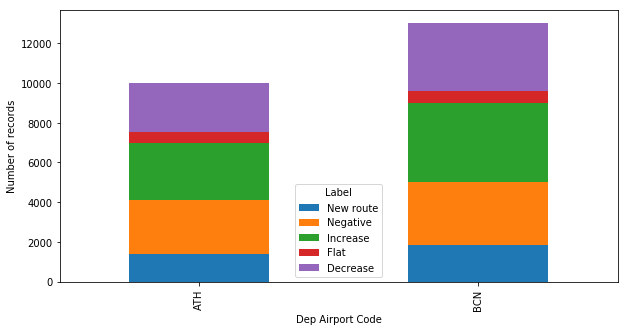

In [6]:
data_airport = data.groupby(['Dep Airport Code'])['Label'].value_counts().to_frame().rename(columns={'Label':'count'}).reset_index().sort_values(['Dep Airport Code','Label'])
#airports_chart = ['AGP','ARN','ATH','AYT']
airports_chart = airport_list

pivot_data_airport= data_airport[data_airport['Dep Airport Code'].isin(airports_chart)].pivot(index='Dep Airport Code', columns='Label', values='count')
plot = pivot_data_airport.loc[:,['New route','Negative','Increase','Flat','Decrease']].plot.bar(stacked=True, figsize=(10,5))
plot = plot.set_ylabel('Number of records')

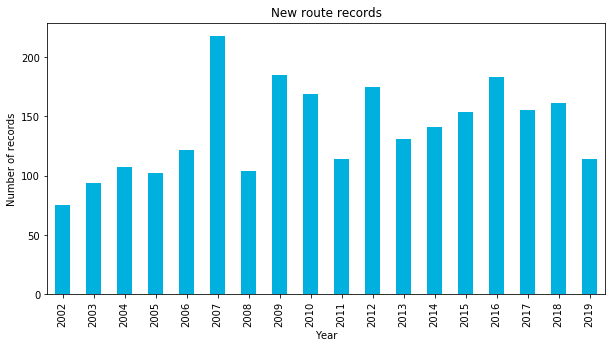

In [7]:
airports_chart = airport_list
data_year = data[data['Dep Airport Code'].isin(airports_chart)].groupby(['Year'])['Label'].value_counts().to_frame().rename(columns={'Label':'count'}).reset_index().sort_values(['Year','Label'])

pivot_data_year= data_year.pivot(index='Year', columns='Label', values='count')
#plot = pivot_data_year.loc[2002:2019,['New route','Negative','Increase','Flat','Decrease']].plot.bar(stacked=True, figsize=(10,5))
cat_plot = 'New route'
plot = pivot_data_year.loc[2002:2019,cat_plot].plot.bar(stacked=False, figsize=(10,5),color=(0/255,176/255,223/255),title=cat_plot+' records')
plot = plot.set_ylabel('Number of records')

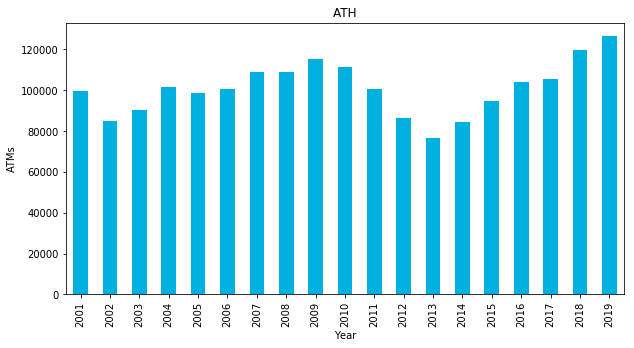

In [8]:
airport = 'ATH'
airport_year = data[data['Dep Airport Code']==airport].groupby(['Year','Dep Airport Code'])['Frequency'].sum().to_frame().reset_index()

pivot_airport_year= airport_year.pivot(index='Year', columns='Dep Airport Code', values='Frequency')
plot = pivot_airport_year.loc[2001:2019,airport].plot.bar(stacked=False, figsize=(10,5),color=(0/255,176/255,223/255),title=airport)
plot = plot.set_ylabel('ATMs')

In [9]:
data.isna().sum()

Dep Airport Code                0
Dep IATA Country Name           0
Carrier Code                    0
Mainline/Low Cost               0
Arr Airport Code                0
Arr IATA Country Name           0
Region                          0
Year                            0
Season                          0
GCD (km)                        7
Flight Time                     7
Frequency                       0
Seats (Total)                   0
Frequency_prev_year             0
is_new_route_airline            0
Frequency_prev_year_route       0
is_new_route                    0
is_new_airline                  0
yoychange                       0
n_airlines_prev_year            0
pct_change_prev              2528
pct_change_prev_airline      2151
pct_change_prev_route        1828
pct_change_prev_region       1860
pct_change_prev_airport      1788
stopped_next_year            5899
yoychange_next               5899
Seasonal                        0
Indirect_Pax_prev_year          0
Dir_Pax_prev_y

In [10]:
data_clean = data.drop(['pct_change_prev','stopped_next_year','yoychange_next'],axis=1)

In [11]:
data_clean.isna().sum()

Dep Airport Code                0
Dep IATA Country Name           0
Carrier Code                    0
Mainline/Low Cost               0
Arr Airport Code                0
Arr IATA Country Name           0
Region                          0
Year                            0
Season                          0
GCD (km)                        7
Flight Time                     7
Frequency                       0
Seats (Total)                   0
Frequency_prev_year             0
is_new_route_airline            0
Frequency_prev_year_route       0
is_new_route                    0
is_new_airline                  0
yoychange                       0
n_airlines_prev_year            0
pct_change_prev_airline      2151
pct_change_prev_route        1828
pct_change_prev_region       1860
pct_change_prev_airport      1788
Seasonal                        0
Indirect_Pax_prev_year          0
Dir_Pax_prev_year               0
LF_route_prev_year              0
AvLF_airline_prev_year          0
Dep_GDP       

In [12]:
data_clean = data_clean.dropna().reset_index(drop=True)

In [13]:
len(data_clean)/len(data)

0.8225687356122139

In [14]:
data_clean = data_clean.drop(['Dep Airport Code', 'Dep IATA Country Name', 'Carrier Code',\
    'Arr Airport Code', 'Arr IATA Country Name', 'Year'],axis=1)

In [15]:
data_clean.dtypes

Mainline/Low Cost             object
Region                        object
Season                        object
GCD (km)                     float64
Flight Time                  float64
Frequency                    float64
Seats (Total)                float64
Frequency_prev_year          float64
is_new_route_airline           int64
Frequency_prev_year_route    float64
is_new_route                 float64
is_new_airline                 int64
yoychange                      int64
n_airlines_prev_year         float64
pct_change_prev_airline      float64
pct_change_prev_route        float64
pct_change_prev_region       float64
pct_change_prev_airport      float64
Seasonal                       int64
Indirect_Pax_prev_year       float64
Dir_Pax_prev_year            float64
LF_route_prev_year           float64
AvLF_airline_prev_year       float64
Dep_GDP                      float64
Arr_GDP                      float64
Label                         object
dtype: object

In [16]:
data_clean = pd.get_dummies(data_clean,columns=['Mainline/Low Cost','Region','Season','is_new_route_airline','is_new_route',\
                                                'is_new_airline','yoychange','Seasonal'])

In [17]:
data_clean.head()

,GCD (km),Flight Time,Frequency,Seats (Total),Frequency_prev_year,Frequency_prev_year_route,n_airlines_prev_year,pct_change_prev_airline,pct_change_prev_route,pct_change_prev_region,...,is_new_route_airline_1,is_new_route_0.0,is_new_route_1.0,is_new_airline_0,is_new_airline_1,yoychange_-1,yoychange_0,yoychange_1,Seasonal_0,Seasonal_1
0,1872.000000,176.142857,76.0,11412.0,0.0,0.0,0.0,0.000000,0.000000,0.131542,...,1,0,1,0,1,0,0,1,1,0
1,2042.232432,194.743243,194.0,30025.0,0.0,175.0,2.0,1.020161,0.035503,0.091332,...,1,1,0,1,0,0,0,1,1,0
2,309.026413,52.495675,34.0,1564.0,0.0,1829.0,3.0,1.020161,0.093246,0.069614,...,1,1,0,1,0,0,0,1,0,1
3,309.026413,52.495675,25.0,1150.0,0.0,1426.0,3.0,-0.242991,0.152789,-0.015951,...,1,1,0,1,0,0,0,1,0,1
4,134.348332,39.542281,23.0,1058.0,1.0,1693.0,4.0,-0.504990,0.168392,0.055474,...,1,1,0,1,0,0,0,1,0,1


In [18]:
def min_max(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def normaliser(x):
    return (x-np.mean(x))/(np.max(x)-np.min(x))

def standardiser(x):
    return (x-np.mean(x))/(np.std(x))

In [19]:
data_clean.dtypes

GCD (km)                     float64
Flight Time                  float64
Frequency                    float64
Seats (Total)                float64
Frequency_prev_year          float64
Frequency_prev_year_route    float64
n_airlines_prev_year         float64
pct_change_prev_airline      float64
pct_change_prev_route        float64
pct_change_prev_region       float64
pct_change_prev_airport      float64
Indirect_Pax_prev_year       float64
Dir_Pax_prev_year            float64
LF_route_prev_year           float64
AvLF_airline_prev_year       float64
Dep_GDP                      float64
Arr_GDP                      float64
Label                         object
Mainline/Low Cost_L            uint8
Mainline/Low Cost_M            uint8
Region_Africa                  uint8
Region_Asia                    uint8
Region_Domestic                uint8
Region_Europe                  uint8
Region_Latin America           uint8
Region_Middle East             uint8
Region_North America           uint8
S

In [20]:
data_clean_scaled = data_clean.copy()

In [21]:
data_clean_scaled[list(data_clean_scaled.loc[:,'GCD (km)':'Arr_GDP'])] = data_clean_scaled[list(data_clean_scaled.loc[:,'GCD (km)':'Arr_GDP'])].apply(lambda x: standardiser(x))

In [22]:
data_clean_scaled.head()

,GCD (km),Flight Time,Frequency,Seats (Total),Frequency_prev_year,Frequency_prev_year_route,n_airlines_prev_year,pct_change_prev_airline,pct_change_prev_route,pct_change_prev_region,...,is_new_route_airline_1,is_new_route_0.0,is_new_route_1.0,is_new_airline_0,is_new_airline_1,yoychange_-1,yoychange_0,yoychange_1,Seasonal_0,Seasonal_1
0,0.068646,0.022446,-0.465318,-0.440864,-0.521358,-0.550271,-1.426681,-0.103477,-0.189821,0.386359,...,1,0,1,0,1,0,0,1,1,0
1,0.164369,0.159616,-0.134425,-0.120166,-0.521358,-0.373859,0.183143,0.183606,-0.110818,0.215460,...,1,1,0,1,0,0,0,1,1,0
2,-0.810226,-0.889402,-0.583094,-0.610543,-0.521358,1.293482,0.988055,0.183606,0.017674,0.123153,...,1,1,0,1,0,0,0,1,0,1
3,-0.810226,-0.889402,-0.608331,-0.617676,-0.521358,0.887231,0.988055,-0.171857,0.150174,-0.240517,...,1,1,0,1,0,0,0,1,0,1
4,-0.908449,-0.984928,-0.613940,-0.619261,-0.518618,1.156385,1.792967,-0.245586,0.184894,0.063055,...,1,1,0,1,0,0,0,1,0,1


In [23]:
data_prediction = data_clean_scaled[data_clean_scaled['Label'].isin(['New route','Negative'])]
labels = data_prediction['Label']
data_prediction = data_prediction.drop(['Label'],axis=1)

In [24]:
labels.values

array(['Negative', 'Negative', 'New route', ..., 'Negative', 'Negative',
       'Negative'], dtype=object)

In [25]:
from sklearn.model_selection import train_test_split

# split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(data_prediction, labels, 
                                                    test_size=0.25, random_state=42)

In [26]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, recall_score, accuracy_score

# define logistic regression model
model = LogisticRegression(random_state=42)

# fit the model using the training data
model = model.fit(x_train, y_train)
    
# make prediction on test set
y_logistic = model.predict(x_test)

# calculate performance metrics
score = fbeta_score(y_test, y_logistic, beta=2, pos_label='New route')
recall = recall_score(y_test,y_logistic, pos_label='New route')   
accuracy = accuracy_score(y_test,y_logistic)

print('Performance of logistic regression model on test dataset:')
print('F-score = {:.2f}%'.format(score*100))
print('Recall = {:.2f}%'.format(recall*100))
print('Accuracy = {:.2f}%'.format(accuracy*100))

Performance of logistic regression model on test dataset:
F-score = 56.19%
Recall = 54.16%
Accuracy = 77.87%


In [28]:
len(y_train[y_train=='New route'])/len(y_train)

0.30622204148027654

In [29]:
# Algorithm spot-check
from sklearn.metrics import fbeta_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

def predictor(classifier, X, y, test_size=0.25, beta=2):
    
    # split dataset into training and test subsets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # fit the model using the training data
    model = classifier.fit(x_train, y_train)
    
    # make prediction on first 500 samples of training set
    y_pred_train = model.predict(x_train[:500])
    
    # make prediction on test set
    y_pred_test = model.predict(x_test)
    
    # calculate f-score, recall and accuracy on training and test set
    score_train = fbeta_score(y_train[:500], y_pred_train, beta, pos_label='New route')
    score_test = fbeta_score(y_test, y_pred_test, beta, pos_label='New route')
    
    recall_train = recall_score(y_train[:500],y_pred_train, pos_label='New route')
    recall_test = recall_score(y_test,y_pred_test, pos_label='New route')
    
    accuracy_train = accuracy_score(y_train[:500],y_pred_train)
    accuracy_test = accuracy_score(y_test,y_pred_test)
    
    fscore = [score_train,score_test]
    recall = [recall_train,recall_test]
    accuracy = [accuracy_train,accuracy_test]
        
    return fscore, recall, accuracy, y_pred_test, y_pred_train

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

# Dictionary containing all classification models to be tested
models = dict()

models['Logistic'] = LogisticRegression(random_state=42)
models['Decision Tree'] = DecisionTreeClassifier(random_state=42)
models['Linear SVM'] = SVC(kernel='linear', random_state=42)
models['Cubic SVM'] = SVC(kernel='poly', random_state=42)
for c in np.arange(0.1, 1.1, 0.1):
    models['RBF SVM (C = '+str(c)+')'] = SVC(C=c, random_state=42)
models['Naive Bayes'] = GaussianNB()
models['Bagging'] = BaggingClassifier(n_estimators=50 ,random_state=42)
models['Random Forest'] = RandomForestClassifier(n_estimators=50, random_state=42)
models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=50 ,random_state=42)
models['AdaBoost'] = AdaBoostClassifier(n_estimators=50 ,random_state=42)

In [31]:
scores = []
recalls = []
accuracies = []

for model in models:
    
    score, recall, accuracy, y_pred_test, y_pred_train = predictor(models[model], data_prediction, labels)
    
    scores.append(score[1])
    recalls.append(recall[1])
    accuracies.append(recall[1])
    
    print(model)
    print('\nTraining set')
    print('F-score = {:.2f}%'.format(score[0]*100))
    print('Recall = {:.2f}%'.format(recall[0]*100))
    print('Accuracy = {:.2f}%'.format(accuracy[0]*100))
    print('\nTest set')
    print('F-score = {:.2f}%'.format(score[1]*100))
    print('Recall = {:.2f}%'.format(recall[1]*100))
    print('Accuracy = {:.2f}%'.format(accuracy[1]*100))
    print('----------------------------------------------')

Logistic

Training set
F-score = 61.71%
Recall = 60.27%
Accuracy = 80.20%

Test set
F-score = 56.19%
Recall = 54.16%
Accuracy = 77.87%
----------------------------------------------
Decision Tree

Training set
F-score = 100.00%
Recall = 100.00%
Accuracy = 100.00%

Test set
F-score = 70.02%
Recall = 70.59%
Accuracy = 81.10%
----------------------------------------------
Linear SVM

Training set
F-score = 64.07%
Recall = 63.01%
Accuracy = 80.80%

Test set
F-score = 59.01%
Recall = 57.40%
Accuracy = 78.48%
----------------------------------------------
Cubic SVM

Training set
F-score = 49.02%
Recall = 44.52%
Accuracy = 81.00%

Test set
F-score = 44.82%
Recall = 40.57%
Accuracy = 78.54%
----------------------------------------------
RBF SVM (C = 0.1)

Training set
F-score = 37.04%
Recall = 32.88%
Accuracy = 77.20%

Test set
F-score = 38.51%
Recall = 34.48%
Accuracy = 76.34%
----------------------------------------------
RBF SVM (C = 0.2)

Training set
F-score = 50.96%
Recall = 47.26%
Accur

In [32]:
print('Best model (highest recall): {}'.format(list(models.keys())[recalls.index(max(recalls))]))
print('Recall = {:.2f}%'.format(max(recalls)*100))

Best model (highest recall): Bagging
Recall = 76.88%


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score

# Initialize imblearn pipeline with chosen unoptimized classifier.
# note: using a pipeline rather than just a classifier makes it possible to use SMOTE to over-sample the training set used in the Grid Search
model = BaggingClassifier(random_state=42)

# Parameters to be tuned
params = {'n_estimators':[20, 50, 100, 200, 300, 400, 500],'max_features':[0.2,0.4,0.6,0.8,1]}

# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2, pos_label='New route')

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(data_prediction, labels, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer, n_jobs=-1, verbose = 5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(x_train,y_train)

# Get the optimised estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimised and optimised model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimised model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2, pos_label='New route')*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions, pos_label='New route')*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimised Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2, pos_label='New route')*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions, pos_label='New route')*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s


KeyboardInterrupt: 

In [47]:
# Parameters to be tuned
params = {'base_estimator__max_depth':range(3,20,2), 'base_estimator__min_samples_split':range(2,201,25)}
model = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500, max_features=0.8, random_state=42)  

# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2,pos_label='New route')

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(data_prediction, labels, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer, n_jobs=-1, verbose = 5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(x_train,y_train)

# Get the optimised estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimised and optimised model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimised model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2, pos_label='New route')*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions, pos_label='New route')*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimised Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2, pos_label='New route')*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions, pos_label='New route')*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 22.2min finished


Unoptimised model
------------
F-score on test data: 78.19%
Recall on test data: 78.09%
Accuracy score on test data: 87.01%

Optimised Model
------------
Final F-score on the test data: 78.56%
Final recall on the test data: 78.50%
Final accuracy score on the test data: 87.20%

Optimal parameters:
{'base_estimator__max_depth': 19, 'base_estimator__min_samples_split': 2}
